# **Importing Necessary Libraries**

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
import cv2
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg19 import VGG19

## **Setting The paths**

In [18]:
train_dir = 'dataset/training'
validation_dir = 'dataset/validation'
test_dir = 'dataset/testing'


# **Preprocessing the Data**

In [3]:
Batch_SIZE = 16
img_size = 150

In [4]:
train_datagen = ImageDataGenerator(rescale= 1./255,
                                   rotation_range = 20,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   width_shift_range = 0.1,
                                   height_shift_range= 0.1,
                                   fill_mode='constant')

In [5]:
validation_datagen = ImageDataGenerator(rescale= 1./255)

In [6]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = Batch_SIZE,
                                                    class_mode = 'categorical')

Found 1000 images belonging to 5 classes.


In [8]:
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = Batch_SIZE,
                                                    class_mode = 'categorical')

Found 125 images belonging to 5 classes.


In [9]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = Batch_SIZE,
                                                    class_mode = 'categorical')

Found 125 images belonging to 5 classes.


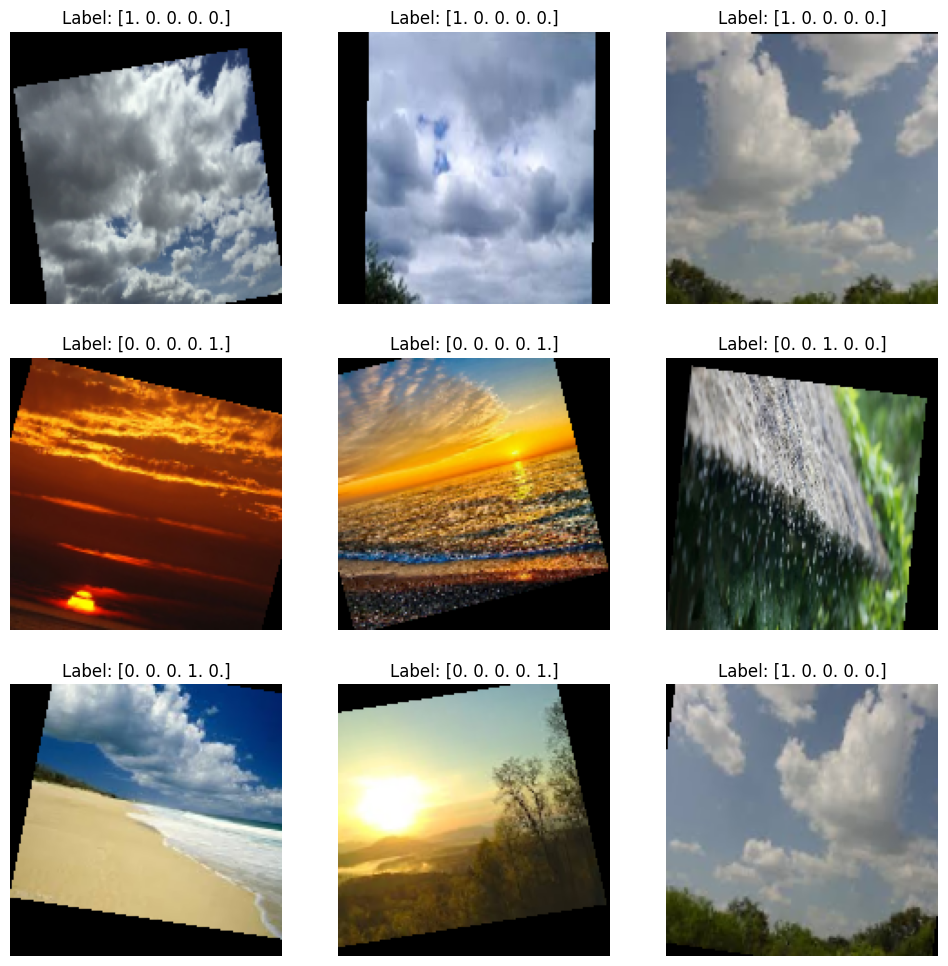

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    image, label = next(iter(train_generator))
    ax.imshow(image[0])
    ax.set_title(f"Label: {label[0]}")
    ax.axis('off')
plt.show()

# **Using Transfer Learning for our model**

In [11]:
vgg = VGG19(weights = "imagenet",include_top=False,input_shape=(img_size,img_size,3))

In [12]:
for layer in vgg.layers:
    layer.trainable = False

In [13]:
model = Sequential()
model.add(Input(shape=(img_size, img_size, 3)))
model.add(vgg)
model.add(Flatten())
model.add(Dense(256 , activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(128 , activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(5,activation = "softmax"))

In [14]:
model.compile(optimizer= Adam(learning_rate= 0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 4, 4, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,155,333 (84.52 MB)

 Trainable params: 2,130,949 (8.13 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [16]:
vgg19_history = model.fit(train_generator , validation_data= validation_generator , epochs= 2)

Epoch 1/2


c:\Users\PMLS\.conda\envs\lung\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.2639 - loss: 1.9861 - val_accuracy: 0.6720 - val_loss: 1.1224
Epoch 2/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.5083 - loss: 1.1964 - val_accuracy: 0.6880 - val_loss: 0.9061


## **Plotting The Accuracy and Losses**

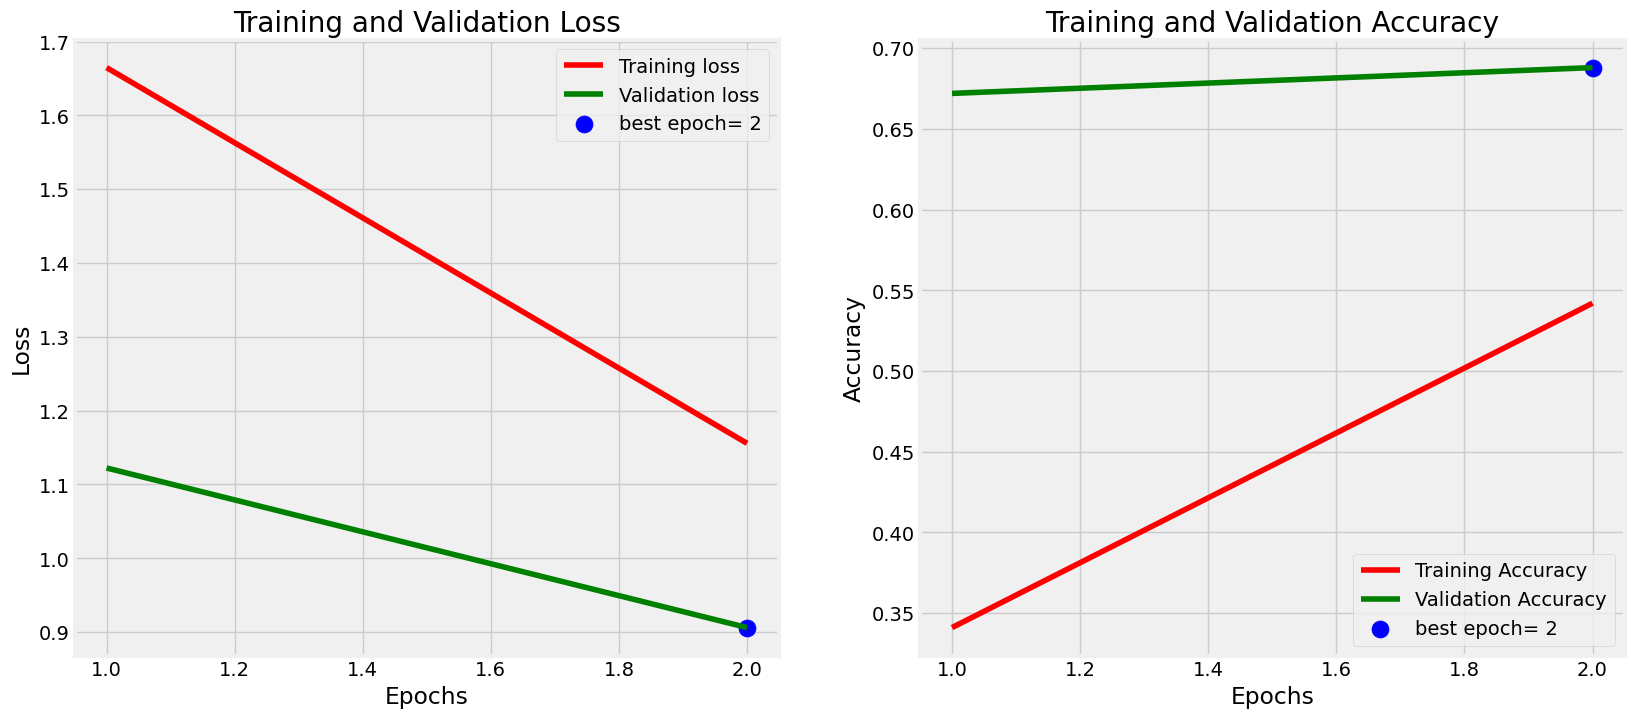

In [19]:
# Define needed variables
tr_acc = vgg19_history.history['accuracy']
tr_loss = vgg19_history.history['loss']
val_acc = vgg19_history.history['val_accuracy']
val_loss = vgg19_history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## **Evaluating on Validation and Test data**

In [21]:
#train_score = model.evaluate(train_generator, verbose= 1)
valid_score = model.evaluate(validation_generator, verbose= 1)
test_score = model.evaluate(test_generator, verbose= 1)

#print("Train Loss: ", train_score[0])
#print("Train Accuracy: ", train_score[1])
#print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 768ms/step - accuracy: 0.6786 - loss: 0.9267


c:\Users\PMLS\.conda\envs\lung\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 744ms/step - accuracy: 0.5904 - loss: 1.0063
Validation Loss:  0.9061357378959656
Validation Accuracy:  0.6880000233650208
--------------------
Test Loss:  1.0179961919784546
Test Accuracy:  0.6079999804496765


## **Saving the model**

In [22]:
model.save("vgg19_weather.h5")

# **Making Some Predictions on test data**

In [24]:
indices = train_generator.class_indices
print(indices)

{'cloudy': 0, 'foggy': 1, 'rainy': 2, 'shine': 3, 'sunrise': 4}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Real: rainy ,Predicted: rainy


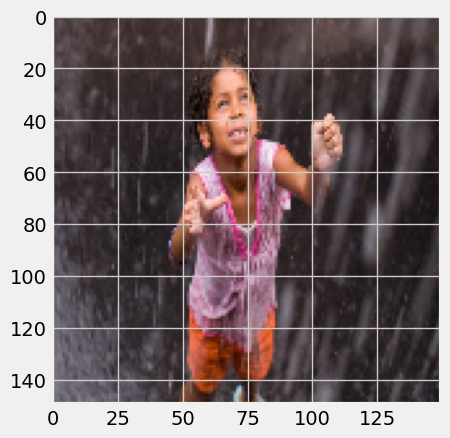

In [37]:
path = 'dataset/testing/rainy/rain237.jpg'
img=load_img(path, target_size=(img_size, img_size))
x=img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(images)
plt.imshow(img)

max_value = max(classes[0])
max_index = list(classes[0]).index(max_value)

np.around(classes[0], decimals = 2)
print('Real: rainy', ',Predicted:',list(indices.keys())[max_index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Real: cloudy ,Predicted: cloudy


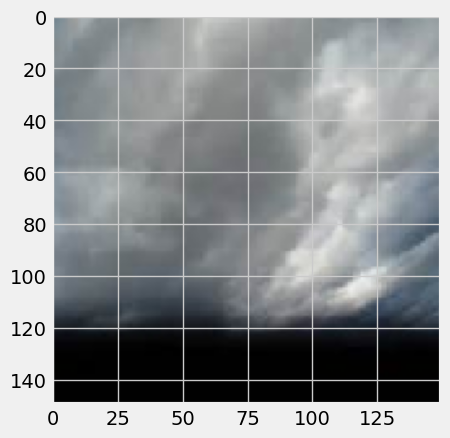

In [40]:
path = 'dataset/testing/cloudy/cloudy226.jpg'
img=load_img(path, target_size=(img_size, img_size))
x=img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(images)
plt.imshow(img)

max_value = max(classes[0])
max_index = list(classes[0]).index(max_value)

np.around(classes[0], decimals = 2)
print('Real: cloudy', ',Predicted:',list(indices.keys())[max_index])